In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import ProbabilisticParcellation.functional_profiles as fp
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit

from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
import PcmPy as pcm
from copy import deepcopy
import torch as pt



base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

## Load profile data and model

In [30]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/NettekovenSym32_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
# info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{split_mn[0]}.lut')
labels=labels[1:]

# load profile
profile = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/{fileparts[-1].split("_")[0]}_profile_model.tsv', sep="\t"
)


In [31]:
# Reduce profile to only MDTB Tasks
profile = profile[profile.dataset == 'MDTB']

# Make profile into matrix
profile_mat = profile[labels].to_numpy()

# Normalize profile
profile_scaled = (profile_mat - np.mean(profile_mat, axis=0))


In [32]:
profile.columns

Index(['dataset', 'session', 'condition', 'M1L', 'M2L', 'M3L', 'M4L', 'A1L',
       'A2L', 'A3L', 'A4L', 'D1L', 'D2L', 'D3L', 'D4L', 'S1L', 'S2L', 'S3L',
       'S4L', 'M1R', 'M2R', 'M3R', 'M4R', 'A1R', 'A2R', 'A3R', 'A4R', 'D1R',
       'D2R', 'D3R', 'D4R', 'S1R', 'S2R', 'S3R', 'S4R'],
      dtype='object')

In [33]:
profile

,dataset,session,condition,M1L,M2L,M3L,M4L,A1L,A2L,A3L,...,A3R,A4R,D1R,D2R,D3R,D4R,S1R,S2R,S3R,S4R
0,MDTB,ses-s1,NoGo,-0.008215,-0.156491,-0.082523,-0.185437,0.126139,-0.062506,-0.204015,...,-0.326068,-0.361093,0.043640,-0.173924,-0.034507,-0.146655,0.099749,0.044579,0.053521,-0.124808
1,MDTB,ses-s1,Go,0.057134,0.007272,0.217656,-0.078872,0.335035,0.140877,0.004246,...,-0.190389,-0.216920,0.150914,-0.344232,0.038372,-0.054938,0.101166,-0.020318,-0.045777,-0.151349
2,MDTB,ses-s1,ToM,0.315173,-0.096712,0.013768,-0.042750,-0.053281,-0.060340,-0.077313,...,-0.072948,0.108676,0.279922,0.246440,0.248607,0.109235,0.616675,0.684703,0.337415,0.064492
3,MDTB,ses-s1,VideoAct,-0.003199,0.618491,-0.171241,0.008481,-0.338919,0.170491,0.574017,...,0.504999,0.379272,-0.168390,-0.048221,-0.117513,-0.079796,-0.086147,-0.049927,-0.122049,-0.010918
4,MDTB,ses-s1,VideoKnots,0.061406,0.385310,-0.075846,0.130704,-0.277298,0.004863,0.171814,...,0.127972,0.355042,-0.106467,0.138734,-0.028456,0.038841,0.109284,0.154072,0.153528,0.222663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,MDTB,ses-s2,VisualSearchLarge,0.242359,-0.037410,0.222746,0.085919,0.108949,0.138021,0.068422,...,-0.105719,-0.032457,-0.049918,-0.019705,-0.026804,-0.179741,-0.149540,-0.007787,0.136068,-0.078607
57,MDTB,ses-s2,ToM,0.216430,-0.176314,-0.019033,-0.175213,-0.092075,-0.065569,-0.136562,...,-0.150982,-0.088383,0.237799,0.032331,0.302371,0.051432,0.569486,0.571034,0.252459,-0.105993
58,MDTB,ses-s2,VideoAct,-0.109969,0.360588,-0.163697,0.036947,-0.255870,0.085751,0.545271,...,0.388279,0.230548,-0.238740,-0.245988,-0.133980,-0.137687,-0.119905,0.003023,0.038041,-0.061996
59,MDTB,ses-s2,VideoKnots,-0.027837,0.181650,-0.089752,0.195243,-0.179911,-0.071164,0.125574,...,0.057118,0.240077,-0.109116,-0.073305,-0.099242,0.004243,0.081432,0.158246,0.258062,0.259436


([<matplotlib.axis.YTick at 0x7fa2dd87cfd0>,
 [Text(0, 0, 'NoGo'),
  Text(0, 1, 'Go'),
  Text(0, 2, 'ToM'),
  Text(0, 3, 'VideoAct'),
  Text(0, 4, 'VideoKnots'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 6, 'PleasantScenes'),
  Text(0, 7, 'Math'),
  Text(0, 8, 'DigitJudgement'),
  Text(0, 9, 'CheckerBoard'),
  Text(0, 10, 'SadFaces'),
  Text(0, 11, 'HappyFaces'),
  Text(0, 12, 'IntervalTiming'),
  Text(0, 13, 'MotorImagery'),
  Text(0, 14, 'FingerSimple'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 16, 'Verbal0Back'),
  Text(0, 17, 'Verbal2Back'),
  Text(0, 18, 'Object0Back'),
  Text(0, 19, 'Object2Back'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 21, 'StroopIncon'),
  Text(0, 22, 'StroopCon'),
  Text(0, 23, 'VerbGen'),
  Text(0, 24, 'WordRead'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 26, 'VisualSearchMed'),
  Text(0, 27, 'VisualSearchLarge'),
  Text(0, 28, 'rest'),
  Text(0, 29, 'CPRO'),
  Text(0, 30, 'Prediction'),
  Text(0, 31, 'PredictViol'),
  Text(0, 32, 'PredictScram'),


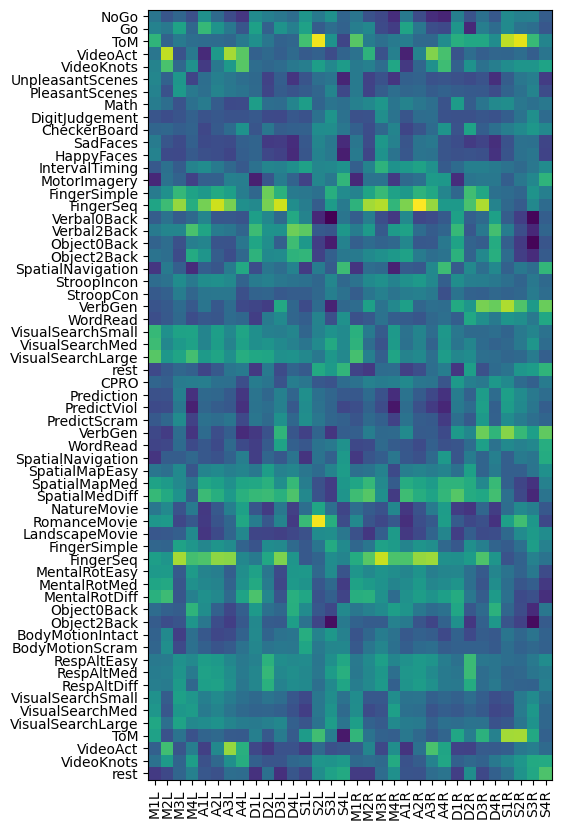

In [34]:
figsize = (10, 10)



# Show scaled profile
plt.figure(figsize=figsize)
plt.imshow(profile_scaled)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(profile)), profile.condition)


([<matplotlib.axis.YTick at 0x7fa2ddc96ca0>,
 [Text(0, 0, 'NoGo'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 10, 'SadFaces'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 30, 'Prediction'),
  Text(0, 35, 'SpatialNavigation'),
  Text(0, 40, 'RomanceMovie'),
  Text(0, 45, 'MentalRotMed'),
  Text(0, 50, 'BodyMotionScram'),
  Text(0, 55, 'VisualSearchMed'),
  Text(0, 60, 'rest')])

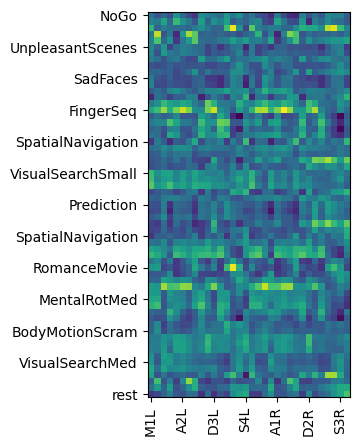

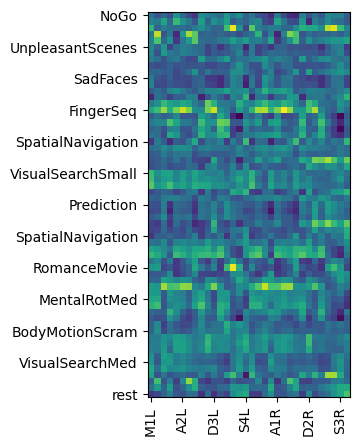

In [35]:
# Show profile

figsize = (5, 5)
# figsize = (40, 20)
plt.figure(figsize=figsize)
plt.imshow(profile_mat)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


# Show scaled profile
plt.figure(figsize=figsize)
plt.imshow(profile_scaled)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


### Load cognitive feature tags

In [36]:
# Load cognitive features
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags_duration.tsv', sep="\t"
)

# Reduce tags to only MDTB Tasks
tags = tags[tags.dataset == 'MDTB']
last_mdtb_tag = tags.columns.tolist().index('right_toe_response_execution')
tags = tags.iloc[:, :last_mdtb_tag]
tags_mat = tags[tags.columns[3:]].to_numpy()

# Print tags for saccadic_eye_movements
print(tags.iloc[:,tags.columns == 'saccadic_eye_movement'])



    saccadic_eye_movement
0                1.866667
1                1.866667
2                3.266667
3                2.066667
4                2.066667
..                    ...
56               3.200000
57               3.266667
58               2.066667
59               2.066667
60               1.500000

[61 rows x 1 columns]


In [37]:
# Subtract mean from each column and divide by standard deviation of each column
tags_mat = (tags_mat - np.mean(tags_mat, axis=0)) / np.std(tags_mat, axis=0)

In [38]:
print(tags_mat[:, tags.iloc[:,3:].columns == 'saccadic_eye_movement'])


[[-0.45166623]
 [-0.45166623]
 [ 1.40873392]
 [-0.18589478]
 [-0.18589478]
 [ 0.34564812]
 [ 0.34564812]
 [-0.36307575]
 [-0.36307575]
 [-0.89461865]
 [ 0.4342386 ]
 [ 0.4342386 ]
 [-1.33757107]
 [-1.11609486]
 [ 0.4342386 ]
 [ 0.4342386 ]
 [-1.1603901 ]
 [-1.1603901 ]
 [-0.71743768]
 [-0.71743768]
 [-0.71743768]
 [-0.98320913]
 [-0.98320913]
 [-0.6288472 ]
 [-0.6288472 ]
 [ 1.32014343]
 [ 1.32014343]
 [ 1.32014343]
 [-0.93891389]
 [ 1.27584819]
 [-0.00871382]
 [-0.00871382]
 [-0.00871382]
 [-0.6288472 ]
 [-0.6288472 ]
 [-0.71743768]
 [-0.80602817]
 [-0.80602817]
 [-0.80602817]
 [ 0.21276239]
 [-0.93891389]
 [-0.36307575]
 [ 0.4342386 ]
 [ 0.4342386 ]
 [ 2.78188641]
 [ 2.78188641]
 [ 2.78188641]
 [-0.71743768]
 [-0.71743768]
 [-0.89461865]
 [-0.89461865]
 [ 0.12417191]
 [ 0.12417191]
 [ 0.12417191]
 [ 1.32014343]
 [ 1.32014343]
 [ 1.32014343]
 [ 1.40873392]
 [-0.18589478]
 [-0.18589478]
 [-0.93891389]]


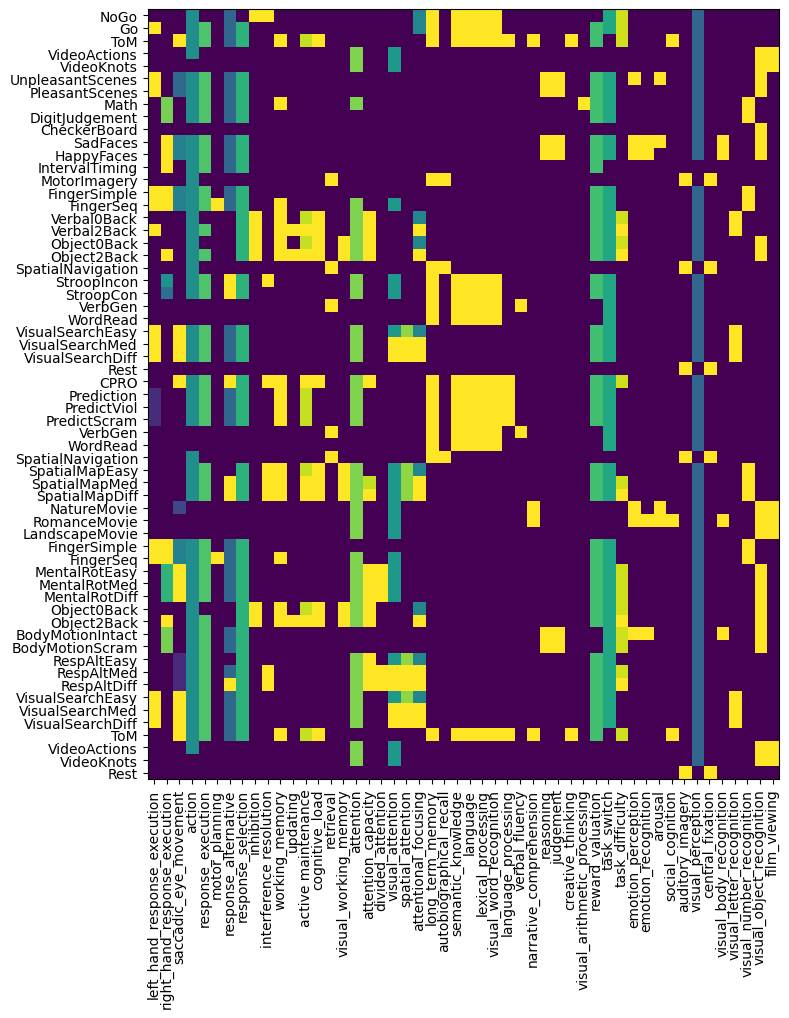

In [39]:
# Show features
plt.figure(figsize=(10, 10))
plt.imshow(tags_mat, vmin=0, vmax=1)
plt.xticks(np.arange(len(tags.columns[3:])), tags.columns[3:], rotation=90)
plt.yticks(np.arange(len(profile[profile.dataset == 'MDTB'])),
           tags[tags.dataset == 'MDTB'].condition)
# Make figure wider
plt.gcf().set_size_inches(100, 10)

([<matplotlib.axis.YTick at 0x7fa27a0d84c0>,
 [Text(0, 0, 'NoGo'),
  Text(0, 1, 'Go'),
  Text(0, 2, 'ToM'),
  Text(0, 3, 'VideoActions'),
  Text(0, 4, 'VideoKnots'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 6, 'PleasantScenes'),
  Text(0, 7, 'Math'),
  Text(0, 8, 'DigitJudgement'),
  Text(0, 9, 'CheckerBoard'),
  Text(0, 10, 'SadFaces'),
  Text(0, 11, 'HappyFaces'),
  Text(0, 12, 'IntervalTiming'),
  Text(0, 13, 'MotorImagery'),
  Text(0, 14, 'FingerSimple'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 16, 'Verbal0Back'),
  Text(0, 17, 'Verbal2Back'),
  Text(0, 18, 'Object0Back'),
  Text(0, 19, 'Object2Back'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 21, 'StroopIncon'),
  Text(0, 22, 'StroopCon'),
  Text(0, 23, 'VerbGen'),
  Text(0, 24, 'WordRead'),
  Text(0, 25, 'VisualSearchEasy'),
  Text(0, 26, 'VisualSearchMed'),
  Text(0, 27, 'VisualSearchDiff'),
  Text(0, 28, 'Rest'),
  Text(0, 29, 'CPRO'),
  Text(0, 30, 'Prediction'),
  Text(0, 31, 'PredictViol'),
  Text(0, 32, 'PredictScram')

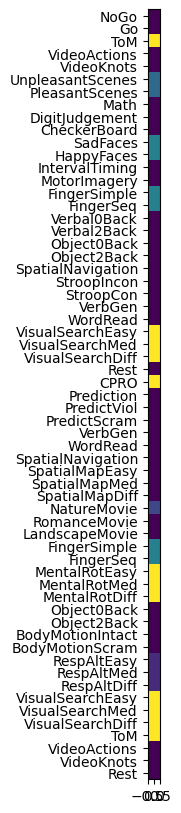

In [40]:
# Show the tags for saccadic_eye_movements
plt.figure(figsize=(10, 10))
show_tag = 'saccadic_eye_movement'
plt.imshow(tags_mat[:, tags.columns[3:].tolist().index(show_tag):tags.columns[3:].tolist().index(show_tag)+1], vmin=0, vmax=1)
plt.yticks(np.arange(len(profile[profile.dataset == 'MDTB'])),
              tags[tags.dataset == 'MDTB'].condition)


In [41]:
R2, features = ridgeFit(profile_mat, tags_mat, fit_intercept=False, voxel_wise=False, alpha=1.0)
# Make dataframe with B values, profile.dataset, profile.condition, tags.columns[3:]
Features = pd.DataFrame(features.T, columns=tags.columns[3:], index=labels)



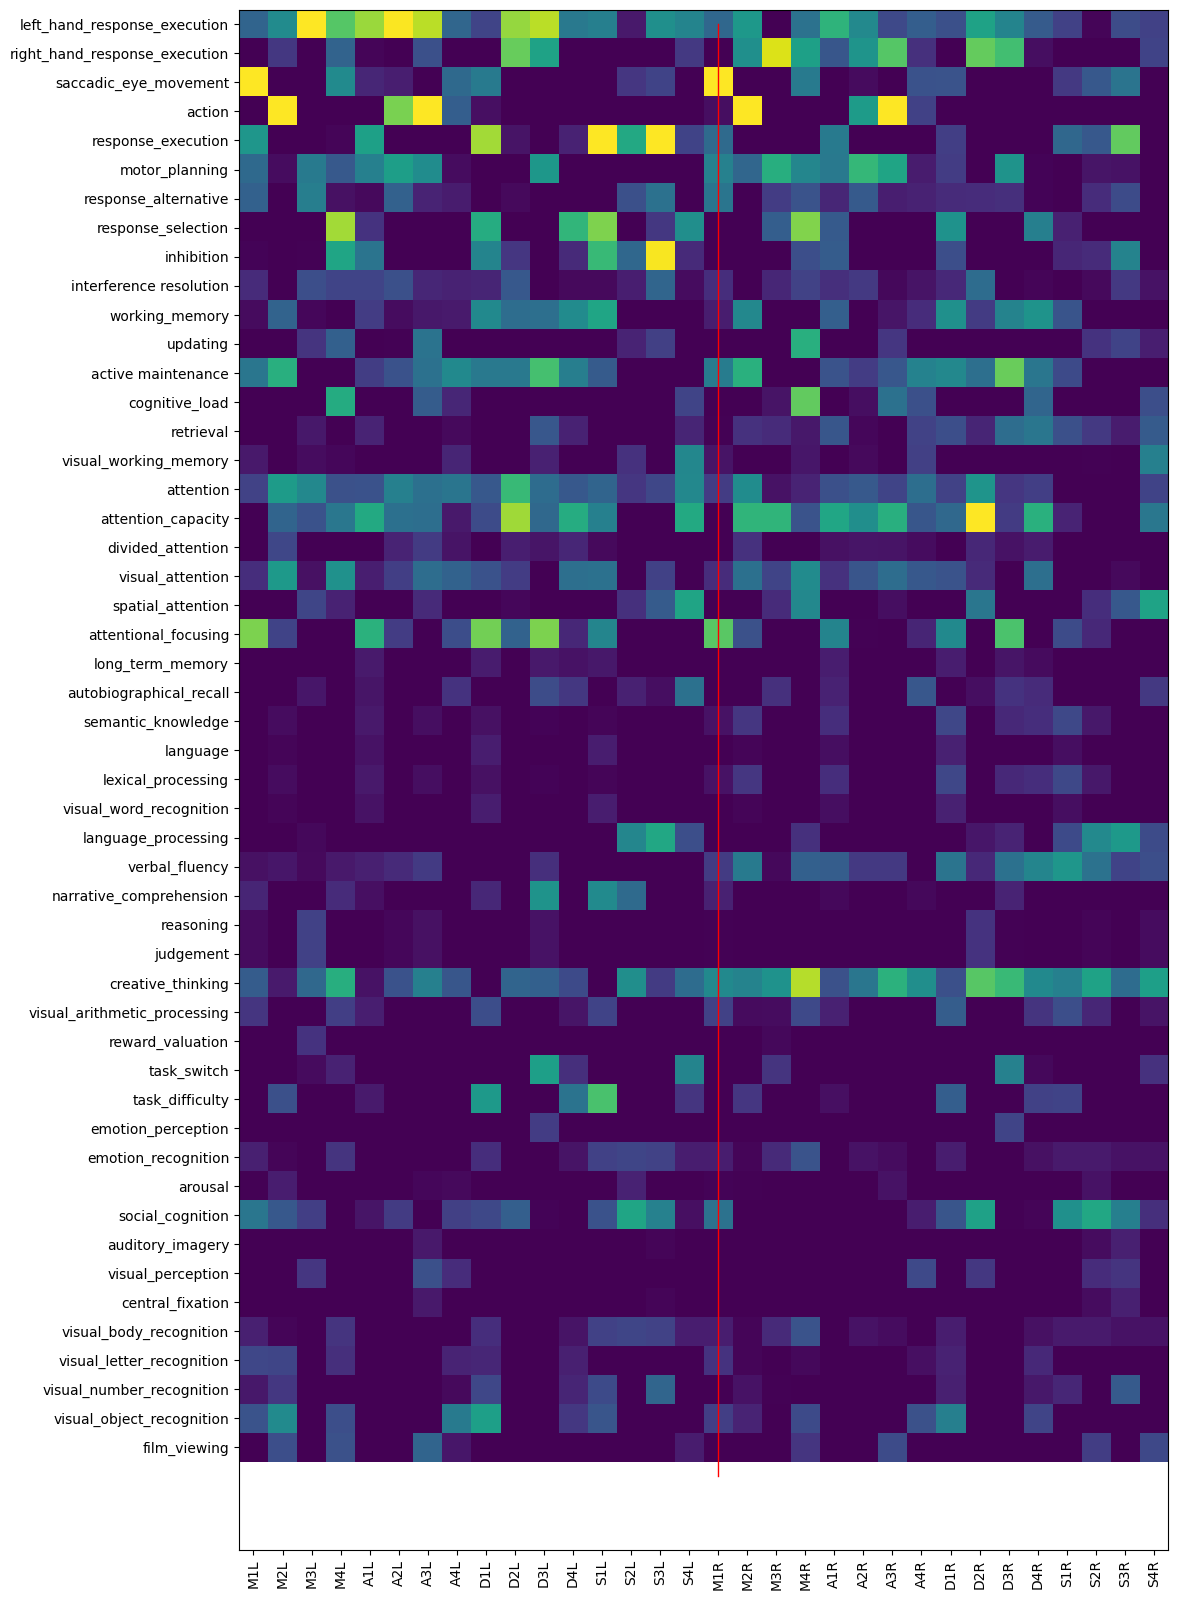

In [42]:
# Plot
plt.figure(figsize=(20, 20))
plt.imshow(features, vmin=0, vmax=0.09)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(tags.columns[3:])), tags.columns[3:])
# Plot a medial line
plt.plot([len(labels)/2, len(labels)/2], [0, len(tags.columns[3:])], color='red', linewidth=1)


In [46]:
profile.columns

Index(['dataset', 'session', 'condition', 'M1L', 'M2L', 'M3L', 'M4L', 'A1L',
       'A2L', 'A3L', 'A4L', 'D1L', 'D2L', 'D3L', 'D4L', 'S1L', 'S2L', 'S3L',
       'S4L', 'M1R', 'M2R', 'M3R', 'M4R', 'A1R', 'A2R', 'A3R', 'A4R', 'D1R',
       'D2R', 'D3R', 'D4R', 'S1R', 'S2R', 'S3R', 'S4R'],
      dtype='object')

([<matplotlib.axis.YTick at 0x7fa289235df0>,
 [Text(0, 0, 'saccadic_eye_movement'),
  Text(0, 1, 'visual_perception'),
  Text(0, 2, 'visual_letter_recognition')])

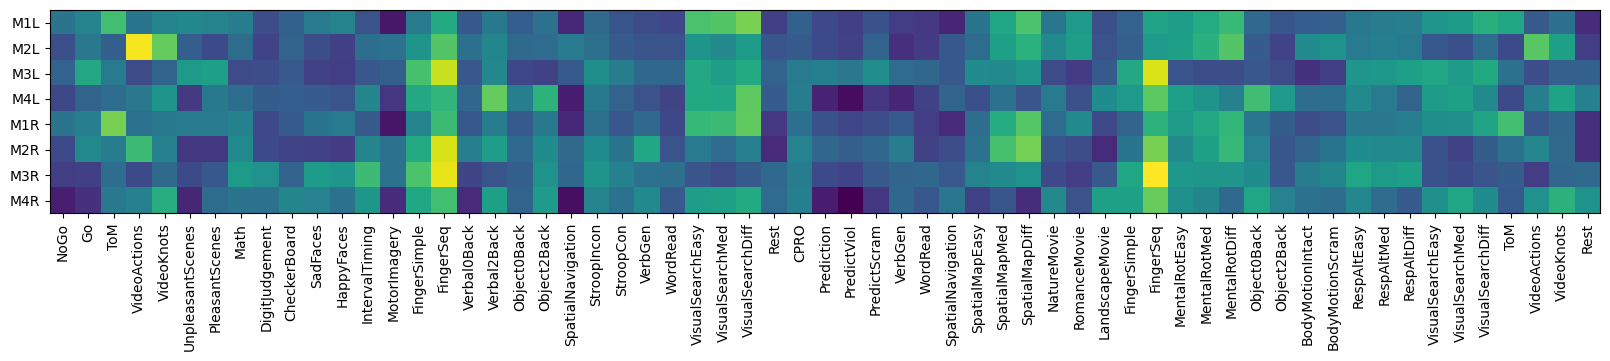

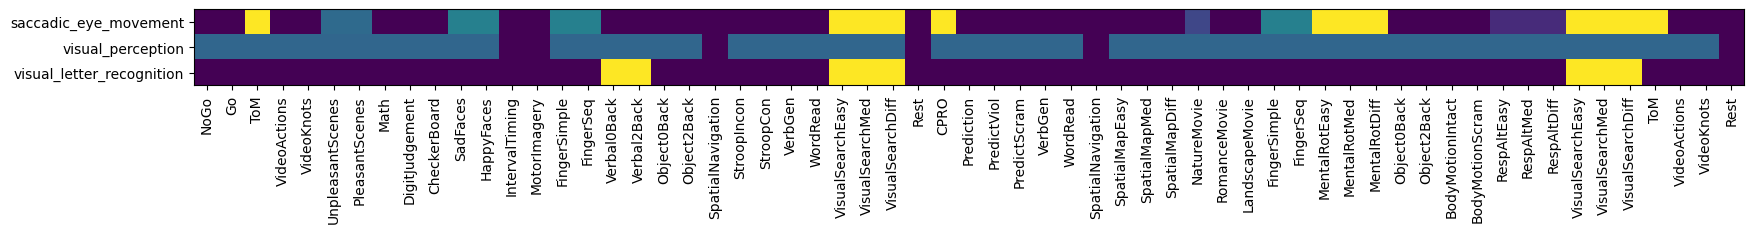

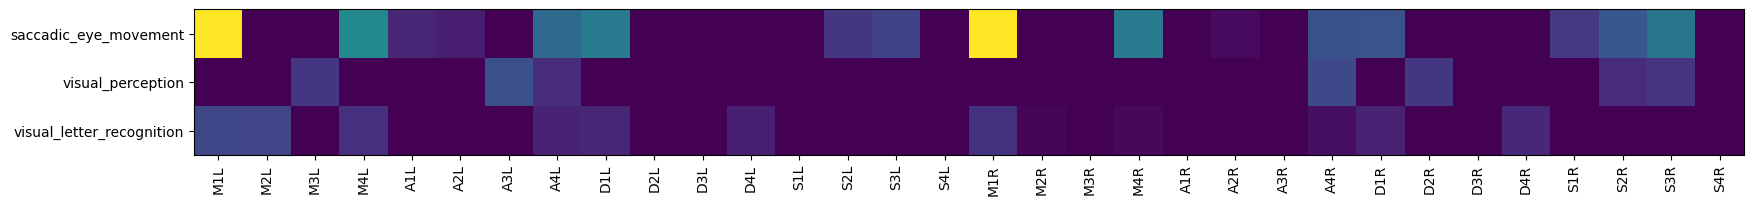

In [53]:
profile_columns = profile.columns[3:].tolist()
tag_columns = tags.columns[3:].tolist()


# Show profile for the show_labels
show_regions = ['M1L', 'M2L', 'M3L', 'M4L', 'M1R', 'M2R', 'M3R', 'M4R']
plt.figure(figsize=(20, 20))
plt.imshow(profile_mat[:, [profile_columns.index(region)
           for region in show_regions]].T)
plt.yticks(np.arange(len(show_regions)), show_regions)
plt.xticks(np.arange(len(profile[profile.dataset == 'MDTB'])),
           tags[tags.dataset == 'MDTB'].condition, rotation=90)

show_tags = ['saccadic_eye_movement',
             'visual_perception', 'visual_letter_recognition']
# Show tags_mat for the show_tags
plt.figure(figsize=(20, 20))
plt.imshow(tags_mat[:, [tag_columns.index(tag) for tag in show_tags]].T, vmin=0, vmax=1)
plt.yticks(np.arange(len(show_tags)), show_tags)
plt.xticks(np.arange(len(profile[profile.dataset == 'MDTB'])),
              tags[tags.dataset == 'MDTB'].condition, rotation=90)

# show matrix for only saccadic_eye_movements, visual_perception, visual_letter_recognition
plt.figure(figsize=(20, 20))
plt.imshow(features[[tag_columns.index(tag)
           for tag in show_tags], :], vmin=0, vmax=0.09)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(show_tags)), show_tags)


In [54]:
def print_tags(profile, df, labels, region=None, n=5):

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = profile[:, i]
            zipped = zip(scores, df.columns)
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds = zip(*zipped[:n])

            [print(f'{cond}: {score}')
             for score, cond in zip(scores, conds)]


In [57]:
for region in ['M1L', 'M1R']:
    print_tags(features, Features, labels, region=region, n=10)



region M1L
saccadic_eye_movement: 0.09402184644269561
attentional_focusing: 0.07214153079455035
response_execution: 0.04744390275118829
active maintenance: 0.035308467251947244
social_cognition: 0.03530746709358519
motor_planning: 0.030738852362209426
left_hand_response_execution: 0.029097599410254058
response_alternative: 0.0279985855550256
creative_thinking: 0.026110689865890633
visual_object_recognition: 0.02293297738784671

region M1R
saccadic_eye_movement: 0.09433738018579432
attentional_focusing: 0.06690080205470864
creative_thinking: 0.04262325706689646
motor_planning: 0.03949643403260736
active maintenance: 0.03780451839301066
response_alternative: 0.03499076199862432
social_cognition: 0.033947828732388094
response_execution: 0.030986911446790236
left_hand_response_execution: 0.0298949585582833
visual_arithmetic_processing: 0.017412053996835097


In [68]:
for region in ['M2L', 'M2R']:
    print_tags(features, Features, labels, region=region, n=10)



region M2L
action: 0.11660561671338547
active maintenance: 0.056744748064111866
attention: 0.049393861080208996
visual_attention: 0.04817413697773204
left_hand_response_execution: 0.04333084471060648
visual_object_recognition: 0.04305265657077767
attention_capacity: 0.029133008787391796
working_memory: 0.028802913051983764
social_cognition: 0.024682984962591144
task_difficulty: 0.02205156778515681

region M2R
action: 0.0917357742978202
attention_capacity: 0.05906198660051504
active maintenance: 0.057080574569344615
left_hand_response_execution: 0.04808894752657328
right_hand_response_execution: 0.04478967027682945
attention: 0.04391615479109391
working_memory: 0.04215300016193688
creative_thinking: 0.040123716537434746
verbal_fluency: 0.036987156643682205
visual_attention: 0.03305752242559751


In [56]:
for region in ['M3R', 'M3L']:
    print_tags(features, Features, labels, region=region, n=10)



region M3R
right_hand_response_execution: 0.08509309315648458
attention_capacity: 0.059010679440929484
motor_planning: 0.05636241958127062
creative_thinking: 0.04596740181728939
response_selection: 0.026971857065263935
visual_attention: 0.018471619714761085
response_alternative: 0.016038703945115623
task_switch: 0.013574675252501273
autobiographical_recall: 0.012462503580049689
spatial_attention: 0.011224696579084993

region M3L
left_hand_response_execution: 0.12388701438507184
attention: 0.04214387784613566
response_alternative: 0.03837692764458734
motor_planning: 0.036891542792359934
creative_thinking: 0.030278260752262663
attention_capacity: 0.02260482474963933
interference resolution: 0.0217655011308136
spatial_attention: 0.01878204905975995
judgement: 0.017297399140217704
reasoning: 0.017297399140197935


In [59]:
for region in ['S1L', 'S1R']:
    print_tags(features, Features, labels, region=region, n=10)



region S1L
response_execution: 0.11054434142324597
response_selection: 0.07271312025156886
task_difficulty: 0.06402863482404926
inhibition: 0.06060466558806552
working_memory: 0.052779321738860775
narrative_comprehension: 0.04299865637762522
attentional_focusing: 0.040978237819045235
attention_capacity: 0.039112085940139575
left_hand_response_execution: 0.03890330968189381
visual_attention: 0.033562914093411673

region S1R
verbal_fluency: 0.04741032737337582
social_cognition: 0.045235665512974005
creative_thinking: 0.03933702519337491
response_execution: 0.029900060534824146
working_memory: 0.023521186438772792
retrieval: 0.02186664701542782
visual_arithmetic_processing: 0.02168396263184066
attentional_focusing: 0.020539203526124886
language_processing: 0.02012388335075612
active maintenance: 0.020088182110851425


In [60]:
for region in ['S2L', 'S2R']:
    print_tags(features, Features, labels, region=region, n=10)



region S2L
response_execution: 0.054332230581326725
social_cognition: 0.05293706121594445
creative_thinking: 0.044451884748307004
language_processing: 0.041151011997638993
narrative_comprehension: 0.031152682129762233
inhibition: 0.03006490829475011
response_alternative: 0.021963592365566838
visual_body_recognition: 0.01895840541248703
emotion_recognition: 0.018958405412486976
attention: 0.014324623569714081

region S2R
social_cognition: 0.054082539501889355
creative_thinking: 0.05180611033770765
language_processing: 0.04243911902444309
verbal_fluency: 0.0340685620116491
response_execution: 0.024749546330013163
saccadic_eye_movement: 0.02461130475797787
film_viewing: 0.01632666941588693
retrieval: 0.015095900086462133
updating: 0.013054449052909752
spatial_attention: 0.01176079985001896


In [63]:
for region in ['D1L', 'D1R']:
    print_tags(features, Features, labels, region=region, n=10)



region D1L
response_execution: 0.07761968858190742
attentional_focusing: 0.07068858345676508
response_selection: 0.05557160391690104
visual_object_recognition: 0.05062693506648535
task_difficulty: 0.04872816169471728
working_memory: 0.042701545762092306
inhibition: 0.04068658812955206
saccadic_eye_movement: 0.03670691624470553
active maintenance: 0.03650804472648676
attention: 0.02478810775399458

region D1R
response_selection: 0.045989501894636485
working_memory: 0.04526442891197798
attentional_focusing: 0.04280878116284354
active maintenance: 0.04186853834779753
visual_object_recognition: 0.038698322379962014
verbal_fluency: 0.034798268816384204
attention_capacity: 0.03040489753034346
task_difficulty: 0.02673987965394841
visual_arithmetic_processing: 0.02653344644097528
social_cognition: 0.0237454204495618


In [64]:
for region in ['D2L', 'D2R']:
    print_tags(features, Features, labels, region=region, n=10)



region D2L
attention_capacity: 0.07732209950233007
left_hand_response_execution: 0.07586127256572386
right_hand_response_execution: 0.06896140986486089
attention: 0.06082026772296008
active maintenance: 0.03635954025258272
working_memory: 0.03208612357255214
creative_thinking: 0.029002631591147045
attentional_focusing: 0.028154455359831437
social_cognition: 0.027287330005288764
interference resolution: 0.024904019888971292

region D2R
attention_capacity: 0.09240081979973891
right_hand_response_execution: 0.06862435918315675
creative_thinking: 0.06663357140598286
left_hand_response_execution: 0.05169164280906896
social_cognition: 0.05156785122109205
attention: 0.04651079448551802
spatial_attention: 0.03528787029694387
active maintenance: 0.032730754778335945
interference resolution: 0.03190090432256222
working_memory: 0.015656478643552914


In [65]:
for region in ['D3L', 'D3R']:
    print_tags(features, Features, labels, region=region, n=10)



region D3L
left_hand_response_execution: 0.08054176247937495
attentional_focusing: 0.07239315257789322
active maintenance: 0.06339562555887339
right_hand_response_execution: 0.0518869876485819
task_switch: 0.05093308253910044
motor_planning: 0.04777708782892252
narrative_comprehension: 0.04616806854720389
working_memory: 0.032919755843301375
attention: 0.03193818069254049
attention_capacity: 0.030463388188078325

region D3R
active maintenance: 0.0695740988440886
attentional_focusing: 0.06462540124748174
right_hand_response_execution: 0.06263273780806276
creative_thinking: 0.06086020602118022
motor_planning: 0.04632687006546816
left_hand_response_execution: 0.04077160026714683
working_memory: 0.040348150563211956
task_switch: 0.039517789610702674
verbal_fluency: 0.03348457120444145
retrieval: 0.03201160527578421


In [66]:
for region in ['A1L', 'A1R']:
    print_tags(features, Features, labels, region=region, n=10)



region A1L
left_hand_response_execution: 0.07662371338100323
attentional_focusing: 0.057470840923584905
attention_capacity: 0.0545458234841321
response_execution: 0.051040929625930556
motor_planning: 0.03928513104886162
inhibition: 0.03466319748965374
attention: 0.02277824608648991
interference resolution: 0.018621410807811094
active maintenance: 0.016475895009065072
working_memory: 0.01601861671982131

region A1R
left_hand_response_execution: 0.05869791236086338
attention_capacity: 0.05339689868881644
attentional_focusing: 0.040512820099366915
response_execution: 0.036933287831969315
motor_planning: 0.03632546606838835
working_memory: 0.02714997161083624
verbal_fluency: 0.026573845469168616
inhibition: 0.02633514524035611
response_selection: 0.025391813008326047
right_hand_response_execution: 0.024120646923980183


In [67]:
for region in ['A2L', 'A2R']:
    print_tags(features, Features, labels, region=region, n=10)



region A2L
left_hand_response_execution: 0.08950052240744205
action: 0.07189096093615852
motor_planning: 0.05061897247886386
attention: 0.03933758869410724
attention_capacity: 0.03339780465864514
response_alternative: 0.02807133081360101
creative_thinking: 0.022835391334656546
active maintenance: 0.022552862624542733
interference resolution: 0.02186263350557894
visual_attention: 0.016610225967189154

region A2R
motor_planning: 0.05993512398699505
action: 0.04929333209340915
right_hand_response_execution: 0.04652019872144063
attention_capacity: 0.04438401309442434
left_hand_response_execution: 0.04226333881177872
creative_thinking: 0.03541985954535255
response_alternative: 0.02537858607689224
attention: 0.02508534861798079
visual_attention: 0.023782962144389613
active maintenance: 0.015936576888101364
